## Importación de librerías

In [ ]:
# Importamos librerias
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from copy import deepcopy as dc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

# Dejamos que pandas nos permita ver todas las columnas
pd.set_option('display.max_columns', None)

## Cargado de datos

In [ ]:
# Cargamos conjunto de datos
credit = pd.read_csv("https://online.stat.psu.edu/onlinecourses/sites/stat508/files/german_credit.csv")
credit_names_short = ["creditability", "balance", "durcredit", "statusprevcredit", "purpose", "amount", "savings", "lenemployment", "instalment",
                      "sexmarital", "guarantors", "duraddress", "mostvalasset", "age", "concurrent", "apartment", "numcreditsbank", "occupation",
                      "numdependents", "phone", "foreignworker"] # Definimos nombres cortos para las columnas
credit_names_long = list(credit.columns)
credit_names = dict(zip(credit_names_short, credit_names_long)) # Usamos dict() y zip() para hacer un diccionario que al insertar el nombre corto nos da el nombre largo
credit.columns = credit_names_short # Asignamos los nombres cortos a los nombres de las columnas del conjunto

In [ ]:
credit.head()

,creditability,balance,durcredit,statusprevcredit,purpose,amount,savings,lenemployment,instalment,sexmarital,guarantors,duraddress,mostvalasset,age,concurrent,apartment,numcreditsbank,occupation,numdependents,phone,foreignworker
0,1,1,18,4,2,1049,1,2,4,2,1,4,2,21,3,1,1,3,1,1,1
1,1,1,9,4,0,2799,1,3,2,3,1,2,1,36,3,1,2,3,2,1,1
2,1,2,12,2,9,841,2,4,2,2,1,4,1,23,3,1,1,2,1,1,1
3,1,1,12,4,0,2122,1,3,3,3,1,2,1,39,3,1,2,2,2,1,2
4,1,1,12,4,0,2171,1,3,4,3,1,4,2,38,1,2,2,2,1,1,2


## Análisis exploratorio

In [ ]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   creditability     1000 non-null   int64
 1   balance           1000 non-null   int64
 2   durcredit         1000 non-null   int64
 3   statusprevcredit  1000 non-null   int64
 4   purpose           1000 non-null   int64
 5   amount            1000 non-null   int64
 6   savings           1000 non-null   int64
 7   lenemployment     1000 non-null   int64
 8   instalment        1000 non-null   int64
 9   sexmarital        1000 non-null   int64
 10  guarantors        1000 non-null   int64
 11  duraddress        1000 non-null   int64
 12  mostvalasset      1000 non-null   int64
 13  age               1000 non-null   int64
 14  concurrent        1000 non-null   int64
 15  apartment         1000 non-null   int64
 16  numcreditsbank    1000 non-null   int64
 17  occupation        1000 non-null   

El conjunto se compone de 1000 renglones, cada uno representando a una persona que esta pidiendo un préstamo. En cada renglón tenemos 20 variables, la primera siendo la variable dependiente del proyecto: Creditability. Este es un valor binario que determina si una persona puede recibir el crédito y que probablemente lo va a liquidar.

El objetivo de este proyecto es generar un modelo que tome en cuenta las variables del conjunto para clasificar a las personas en dos grupos: 1, puede recibir un crédito y 0, no puede recibir un crédito. La intención es asumir correctamente ambos grupos pues al prestar a alguien que no puede liquidar la empresa pierde dinero y también al negar un préstamo a alquien que si puede pagarlo la empresa pierde un cliente potencial.

Se intentarán diferentes modelos, y se observará cuál de todos los modelos clasifica a los clientes potenciales con una mayor tasa de éxito.

Dentro del conjunto no hay valores nulos, y al realiza una pequeña exploración podemos asumir con confianza que no es necesario aplicar pasos de limpieza o procesamiento. Muchos de las variables están en una especie de código o categorización, para entender el significado de cada uno puede dirigirse a esta página: https://online.stat.psu.edu/stat508/lesson/gcd


Las variables de mayor importancia son:
- Credit Amount
- Account Balance
- Age (years)
- Duration of Credit (month)
- Purpose 

En la prueba de modelos se mostrará como se decidió que estas son las variables más importantes

In [ ]:
top_features_list = ['amount', 'balance', 'age', 'durcredit', 'purpose']

top_features = dc(credit[top_features_list])
top_features.columns = list(map(lambda x: credit_names[x], top_features_list))
top_features

,Credit Amount,Account Balance,Age (years),Duration of Credit (month),Purpose
0,1049,1,21,18,2
1,2799,1,36,9,0
2,841,2,23,12,9
3,2122,1,39,12,0
4,2171,1,38,12,0
...,...,...,...,...,...
995,1987,1,21,24,3
996,2303,1,45,24,0
997,12680,4,30,21,0
998,6468,2,52,12,3


In [ ]:
sns.set(rc={'figure.figsize' : (10, 8)})

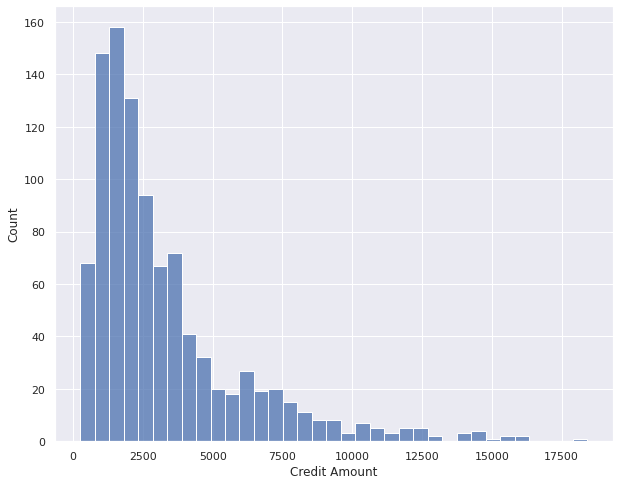

In [ ]:
# Credit Amount
sns.histplot(data = top_features, x = "Credit Amount")

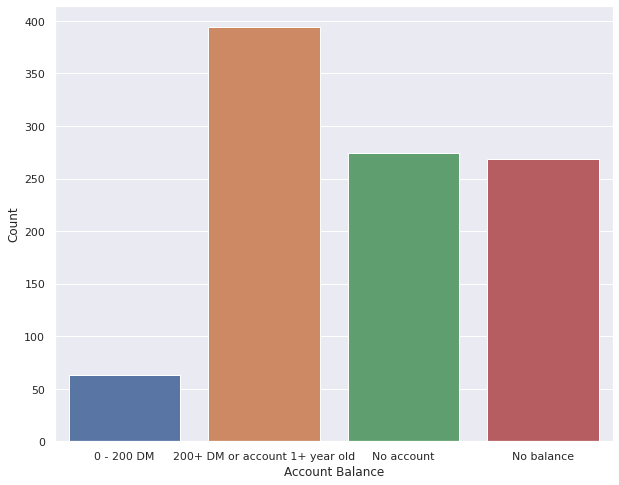

In [ ]:
# Account Balance
balance_dict = {1 : "No account", 2 : "No balance", 3 : "0 - 200 DM", 4 : "200+ DM or account 1+ year old"}

balance_counts = pd.DataFrame()
balance_counts["Count"] = credit["balance"].value_counts().values
balance_counts["Account Balance"] = list(map(lambda x: balance_dict[x], credit["balance"].value_counts().index))
balance_counts = balance_counts.sort_values("Account Balance")
sns.barplot(data = balance_counts, x = "Account Balance", y = "Count")

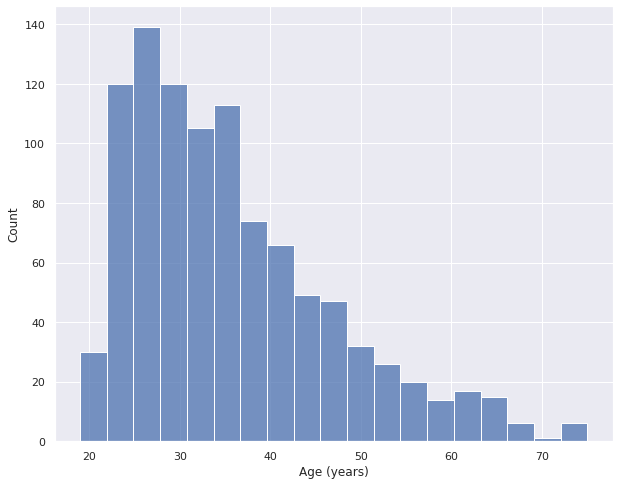

In [ ]:
# Age (years)
sns.histplot(data = top_features, x = "Age (years)")

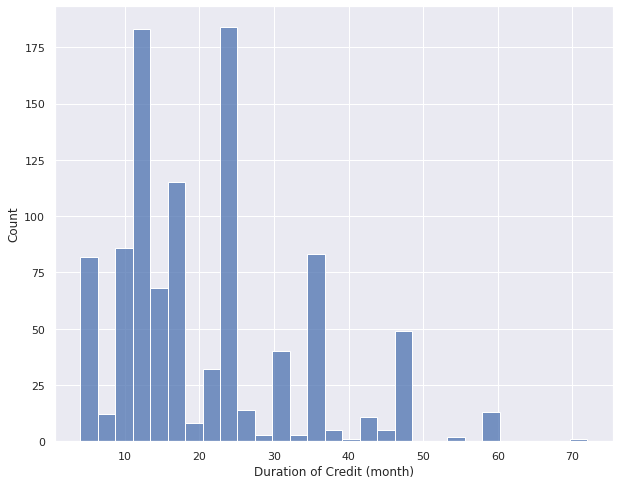

In [ ]:
# Duration of Credit (month)
sns.histplot(data = top_features, x = "Duration of Credit (month)")

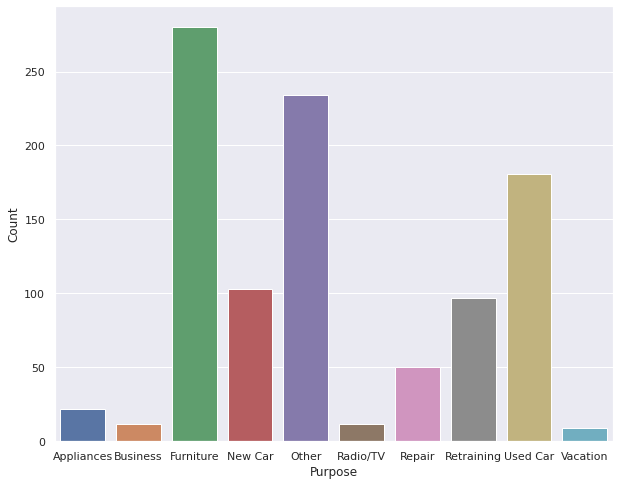

In [ ]:
# Purpose
purpose_dict = {1 : "New Car", 2 : "Used Car", 3 : "Furniture", 4 : "Radio/TV", 5 : "Appliances", 6 : "Repair",
                7 : "Education", 8 : "Vacation", 9 : "Retraining", 10 : "Business", 0 : "Other"}
purpose_counts = pd.DataFrame()
purpose_counts["Count"] = credit["purpose"].value_counts().values
purpose_counts["Purpose"] = list(map(lambda x: purpose_dict[x], credit["purpose"].value_counts().index))
purpose_counts = purpose_counts.sort_values("Purpose")
sns.barplot(data = purpose_counts, x = "Purpose", y = "Count")

In [ ]:
top_features[["Duration of Credit (month)", "Credit Amount", "Age (years)"]].corr() # Estas son las únicas variables del conjunto que no son categóricas

,Duration of Credit (month),Credit Amount,Age (years)
Duration of Credit (month),1.000000,0.624988,-0.037550
Credit Amount,0.624988,1.000000,0.032273
Age (years),-0.037550,0.032273,1.000000


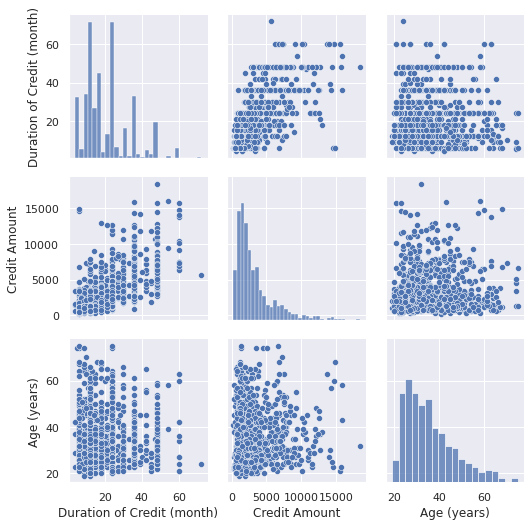

In [ ]:
sns.pairplot(top_features[["Duration of Credit (month)", "Credit Amount", "Age (years)"]]) # Parece haber una correlación no muy duerte de la cantidad del crédito y la duración

## Prueba de modelos

### Creación de conjuntos de entrenamiento y prueba

In [ ]:
X = credit[credit_names_short[1:]] # Se escogen todas las variables menos la primera, creditability
y = credit["creditability"] # Se escoge la variable dependiente

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

### Random Forest

In [ ]:
forest = RandomForestClassifier(random_state = 42)
forest.fit(X_train, y_train)
print(cross_validate(forest, X, y)["test_score"].mean()) # El accuracy score que nos da usando todas las variables y los parámetros default es de 73.6%

0.736


In [ ]:
forest = RandomForestClassifier(random_state = 42)

selector = RFECV(forest) # Usamos un seleccionador de variables con cross-validation
selector.fit(X_train, y_train)
selected_fr = X.columns[selector.support_] # El seleccionador nos regresa el conjunto de variables que nos dará el mejor resultado

forest.fit(X_train[selected_fr], y_train)
# y_pred = forest.predict(X_test[selected]
print(cross_validate(forest, X[selected_fr], y)["test_score"].mean()) # Al usar las variables seleccionadas, nuestro accuracy score baja, pero este valor es más confiable puesto a que fue por un cross-validation de 5 folds

0.725


In [ ]:
forest = RandomForestClassifier(random_state = 42)

# Optimización de parámetros, usando las variables seleccionadas
search = GridSearchCV(forest, {'n_estimators' : [100, 500, 1000], 'criterion' : ['gini', 'entropy'], 'max_depth' : [6, 8, 10]})
search.fit(X_train[selected_fr], y_train)

print(search.best_params_)

{'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 500}


In [132]:
forest = RandomForestClassifier(random_state = 42, criterion = "entropy", max_depth = 8, n_estimators = 500)
forest.fit(X_train[selected_fr], y_train)

y_pred = forest.predict(X_test[selected_fr])

print(cross_validate(forest, X[selected_fr], y)["test_score"].mean()) # Después de usar los mejores parámetros y las variables ideales, nuestro accuracy score solo baja un 3.33% a comparación de la configuración default
# Sin embargo, este modelo es más fiable puesto a que fué por el proceso de cross validation tanto en su selección de variables como su optimización de parámetros
# 73.80%

0.7380000000000001


### Support Vector Machine

In [ ]:
svc = SVC(random_state = 42)
print(cross_validate(svc, X, y)["test_score"].mean())
# All vars, default params, 70.5%

In [ ]:
svc = SVC(random_state = 42, kernel = 'linear') # Se usó el modelo lineal dado que provee un mayor nivel de precisión y se puede usar fácilmente con RFECV
selector_svc = RFECV(svc) 
selector_svc.fit(X_train, y_train)
selected_svc = X.columns[selector_svc.support_]

In [ ]:
print(cross_validate(svc, X[selected_svc], y)["test_score"].mean()) # Vanilla params, selected vars 
# 73.01%

0.7310000000000001


In [ ]:
svc = SVC(random_state = 42, kernel = 'linear')

search = GridSearchCV(svc, {'C' : [0.1, 1, 10, 100]})
search.fit(X_train[selected_svc], y_train)

print(search.best_params_)

{'C': 1}


In [ ]:
svc = SVC(random_state = 42, C = 1, kernel = 'linear')
print(cross_validate(svc, X[selected_svc], y)["test_score"].mean()) # Searched params, selected vars 
# 73.1%

0.7310000000000001


### Regresión Logistica

In [ ]:
logmodel = LogisticRegression(random_state = 42, max_iter = 500)
print(cross_validate(logmodel, X_train, y_train)["test_score"].mean()) # Default params, all variables Test = 75.71%

0.7571428571428571


In [ ]:
logmodel = LogisticRegression(random_state = 42, max_iter = 500)
select = RFECV(logmodel)
select.fit(X_train, y_train)
selected_lr = X.columns[select.support_]
print(selected_lr)

Index(['balance', 'durcredit', 'statusprevcredit', 'purpose', 'savings',
       'lenemployment', 'instalment', 'sexmarital', 'guarantors',
       'mostvalasset', 'concurrent', 'apartment', 'numcreditsbank',
       'occupation', 'phone', 'foreignworker'],
      dtype='object')


In [ ]:
logmodel = LogisticRegression(random_state = 42, max_iter = 500)
print(cross_validate(logmodel, X_train[selected_lr], y_train)["test_score"].mean()) # Default params, selected vars Test = 76.28%

0.7628571428571428


#### Param optimization

In [ ]:
param_dict = {
    "random_state" : [42],
    "max_iter" : [100000],
    "solver" : ["lbfgs"],
    "penalty" : ["l2"],
    "C" : [10, 12.5, 25, 37.5, 50],
    "tol" : [0.00005, 0.0001, 0.0005, 0.001, 0.005],
    "intercept_scaling" : [0.00005, 0.0001, 0.0005, 0.001, 0.005]
} # Optimal, for the moment
# Best params: {'C': 25, 'intercept_scaling': 5e-05, 'max_iter': 100000, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 5e-05}
# Search time: 00:00:25
# CV score: 76.85%

In [ ]:
logmodel = LogisticRegression()

search = GridSearchCV(logmodel, param_dict)
search.fit(X_train[selected_lr], y_train)

print(search.best_params_)

{'C': 25, 'intercept_scaling': 0.01, 'max_iter': 100000, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.01}


In [ ]:
param_dict = {
    "random_state" : [42],
    "max_iter" : [1000000], # lotta zeros
    "solver" : ["liblinear"],
    "penalty" : ["l1"],
    "C" : [10, 12.5, 25, 37.5, 50],
    "tol" : [1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
    "intercept_scaling" : [0.01, 0.1, 1, 10, 100]
} # Optimal, for the moment
# Best params: {'C': 37.5, 'intercept_scaling': 0.1, 'max_iter': 1000000, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.0001}
# Search time: 00:00:16
# CV score: 76.85%

In [ ]:
logmodel = LogisticRegression()

search = GridSearchCV(logmodel, param_dict)
search.fit(X_train[selected_lr], y_train)

print(search.best_params_)

{'C': 37.5, 'intercept_scaling': 0.1, 'max_iter': 1000000, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.0001}


In [ ]:
param_dict = {
    "random_state" : [42],
    "max_iter" : [1000000], # lotta zeros
    "solver" : ["liblinear"],
    "penalty" : ["l2"],
    "C" : [10, 12.5, 25, 37.5, 50],
    "dual" : [True], # split true and false so it doesnt take forever
    "tol" : [1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
    "intercept_scaling" : [0.01, 0.1, 1, 10, 100]
}
# Best params: {'C': 12.5, 'dual': True, 'intercept_scaling': 100, 'max_iter': 1000000, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.01}
# Search time: 04:06:00
# CV score: 74.9%

In [ ]:
logmodel = LogisticRegression()

search = GridSearchCV(logmodel, param_dict)
search.fit(X_train[selected_lr], y_train)

print(search.best_params_)

In [ ]:
param_dict = {
    "random_state" : [42],
    "max_iter" : [1000000], # lotta zeros
    "solver" : ["liblinear"],
    "penalty" : ["l2"],
    "C" : [10, 12.5, 25, 37.5, 50],
    "dual" : [False],
    "tol" : [1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
    "intercept_scaling" : [0.01, 0.1, 1, 10, 100]
} # Optimal, for the moment
# Best params: {'C': 25, 'dual': False, 'intercept_scaling': 10, 'max_iter': 1000000, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.001}
# Training time: 00:00:03
# CV score: 74.9%

In [ ]:
logmodel = LogisticRegression()

search = GridSearchCV(logmodel, param_dict)
search.fit(X_train[selected_lr], y_train)

print(search.best_params_)

In [ ]:
param_dict = {
    "random_state" : [42],
    "max_iter" : [1000000],
    "solver" : ["saga"],
    "penalty" : ["l1", "l2"], # elasticnet needs l1 ratio, so it was moved to the next dict
    "C" : [12.5, 25, 37.5],
    "tol" : [1e-5, 1e-6, 1e-7, 1e-8, 1e-9],
    "intercept_scaling" : [0.00001, 0.0001, 0.001, 0.01, 0.1]
} # Optimal, for the moment
# Best params: {'C': 25, 'intercept_scaling': 1e-05, 'max_iter': 1000000, 'penalty': 'l2', 'random_state': 42, 'solver': 'saga', 'tol': 1e-06}
# Training time: 00:34:20
# CV score: 74.9%

In [ ]:
logmodel = LogisticRegression()

search = GridSearchCV(logmodel, param_dict)
search.fit(X_train[selected_lr], y_train)

print(search.best_params_)

In [ ]:
param_dict = {
    "random_state" : [42],
    "max_iter" : [1000000],
    "solver" : ["saga"],
    "penalty" : ["elasticnet"], 
    "C" : [10, 12.5, 25, 37.5, 50],
    "l1_ratio" : [0.1, 0.25, 0.5, 0.75, 0.9],
    "tol" : [1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
    "intercept_scaling" : [0.01, 0.1, 1, 10, 100]
} 
# Best params: {'C': 25, 'intercept_scaling': 0.01, 'l1_ratio': 0.1, 'max_iter': 1000000, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-06}
# Search time: 01:41:25
# CV score: 74.9%

In [ ]:
logmodel = LogisticRegression()

search = GridSearchCV(logmodel, param_dict)
search.fit(X_train[selected_lr], y_train)

print(search.best_params_)

In [ ]:
# Parameters to play with:
# C
# solver
# tol
# intercept_scaling
# penalty
# l1_ratio (only saga elasticnet)
# dual (only liblinear l2)

In [ ]:
# Warning The choice of the algorithm depends on the penalty chosen.
# Supported penalties by solver: ("None" was excluded)
# ‘lbfgs’ - [‘l2’]
# ‘newton-cg’ - [‘l2’]
# ‘newton-cholesky’ - [‘l2’]
# ‘sag’ - [‘l2’]
# ‘liblinear’ - [‘l1’, ‘l2’]
# ‘saga’ - [‘elasticnet’, ‘l1’, ‘l2’]

In [ ]:
logmodel = LogisticRegression(C = 37.5, intercept_scaling = 0.1, max_iter = 1000000, penalty = "l1", random_state = 42, solver = "liblinear", tol = 0.0001)
print(cross_validate(logmodel, X_train[selected_lr], y_train)["test_score"].mean()) # Best version, 76.85%

0.7671428571428571


In [ ]:
{'C': 37.5, 'intercept_scaling': 0.1, 'max_iter': 1000000, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.0001}

### K Nearest Neighbors

In [ ]:
knn = KNeighborsClassifier()
print(cross_validate(knn, X, y)["test_score"].mean())
# Default params, all vars 64.8 %

0.648


In [ ]:
param_dict = {
    'n_neighbors' : [9, 10, 11, 12, 13],
    'weights' : ['uniform', 'distance'], 
    'algorithm' : ['auto'], # tried others, all searches chose auto always
    'leaf_size' : [1e-10], # doesnt seem to affect result that much
    'p' : [1, 2, 3], # p cant be less than 1 ##
    'n_jobs' : [-1]
}

In [ ]:
knn = KNeighborsClassifier()
search = GridSearchCV(knn, param_dict)
search = search.fit(X_train[selected_fr], y_train)
print(search.best_params_)
# {'algorithm': 'auto', 'leaf_size': 30, 'n_jobs': -1, 'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}
# 68.9%

{'algorithm': 'auto', 'leaf_size': 1e-21, 'n_jobs': -1, 'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}


In [ ]:
knn = KNeighborsClassifier()
search = GridSearchCV(knn, param_dict)
search = search.fit(X_train[selected_svc], y_train)
print(search.best_params_)
# {'algorithm': 'auto', 'leaf_size': 30, 'n_jobs': -1, 'n_neighbors': 11, 'p': 3, 'weights': 'uniform'}
# 71.29%

{'algorithm': 'auto', 'leaf_size': 1e-21, 'n_jobs': -1, 'n_neighbors': 11, 'p': 3, 'weights': 'uniform'}


In [ ]:
knn = KNeighborsClassifier() # Por default KNN no puede usarse con RFECV sin introducir valores de importancia, así que se usarán las mismas variables del Random Forest
search = GridSearchCV(knn, param_dict)
search = search.fit(X_train[selected_lr], y_train)
print(search.best_params_)
# {'algorithm': 'auto', 'leaf_size': 30, 'n_jobs': -1, 'n_neighbors': 11, 'p': 1, 'weights': 'distance'}
# 71.29%

{'algorithm': 'auto', 'leaf_size': 1e-21, 'n_jobs': -1, 'n_neighbors': 11, 'p': 1, 'weights': 'distance'}


In [ ]:
knn = KNeighborsClassifier(algorithm = "auto", leaf_size = 30, n_jobs = -1, n_neighbors = 11,
                           p = 1, weights = "uniform")
print(cross_validate(knn, X[selected_fr], y)["test_score"].mean())

0.689


In [ ]:
knn = KNeighborsClassifier(algorithm = "auto", leaf_size = 30, n_jobs = -1, n_neighbors = 11,
                           p = 3, weights = "uniform")
print(cross_validate(knn, X[selected_svc], y)["test_score"].mean())

0.7129999999999999


In [ ]:
knn = KNeighborsClassifier(algorithm = "auto", leaf_size = 30, n_jobs = -1, n_neighbors = 11,
                           p = 1, weights = "distance")
print(cross_validate(knn, X[selected_lr], y)["test_score"].mean())
# Best model with KNN give 71.29% accuracy

0.7129999999999999


### Clasificador por Redes Neuronales


In [ ]:
mlp = MLPClassifier(hidden_layer_sizes = (20, 20, 20), max_iter = 750, random_state = 42) # Primero se usó (20, 20, 20) para hidden layer sizes, dado que es la cantidad de variables del conjunto con tres capas
print(cross_validate(mlp, X, y)['test_score'].mean())
# Default params & vals 67.9%

0.679


#### Usando vars Random Forest (68.8%)

In [ ]:
len(selected_fr)

16

In [113]:
mlp = MLPClassifier(hidden_layer_sizes = (16, 16, 16), max_iter = 1000, random_state = 42) # Primero se usó (20, 20, 20) para hidden layer sizes, dado que es la cantidad de variables del conjunto con tres capas
print(cross_validate(mlp, X[selected_fr], y)['test_score'].mean())

0.688


#### Usando vars SVC (70.2%)

In [ ]:
len(selected_svc)

17

In [112]:
mlp = MLPClassifier(hidden_layer_sizes = (17, 17, 17), max_iter = 1000, random_state = 42) # Por ultimo se intentó con las variables del SVM
print(cross_validate(mlp, X[selected_svc], y)['test_score'].mean())

0.7020000000000001


#### Usando vars Regresión Logística (70.89%)

In [107]:
len(selected_lr)

16

In [111]:
mlp = MLPClassifier(hidden_layer_sizes = (16, 16, 16, 16), max_iter = 1000, random_state = 42) # Por ultimo se intentó con las variables del SVM
print(cross_validate(mlp, X[selected_lr], y)['test_score'].mean())

0.7089999999999999


#### Ajuste de parámetros

In [129]:
# Ajuste de parámteros
param_dict = {
    "hidden_layer_sizes" : [(17, 17, 17, 17)],
    "solver" : ["adam"],
    "alpha" : [0.0001, 0.0005, 0.00075, 0.001, 0.0025, 0.0075, 0.005],
    "learning_rate" : ["constant"],
    "activation" : ["relu"],
    "learning_rate_init" : [0.0001],
    "max_iter" : [10000]
}

In [130]:
mlp = MLPClassifier(random_state = 42)
search_mlp = GridSearchCV(mlp, param_dict)
search_mlp.fit(X_train[selected_svc], y_train)
print(search_mlp.best_params_)

{'activation': 'relu', 'alpha': 0.0005, 'hidden_layer_sizes': (17, 17, 17, 17), 'learning_rate': 'constant', 'learning_rate_init': 0.0001, 'max_iter': 10000, 'solver': 'adam'}


In [131]:
mlp = MLPClassifier(max_iter = 10000, learning_rate_init = 0.0001, random_state = 42, activation = "relu",
                   hidden_layer_sizes = (17, 17, 17, 17), learning_rate = "constant", solver = "adam", alpha = 0.0005)
print(cross_validate(mlp, X[selected_svc], y)['test_score'].mean())

0.7470000000000001


## Selección de modelos

Mejores resultados:
Obtenidos del promedio de "test_score" que nos dió la cross_validation de cada modelo con la totalidad de X y Y

*   Random Forest: 73.82%
*   Support Vector Machine: 73.10%
*   Regresión Logística: 76.85%
*   K Nearest Neighbors: 71.29%
*   Redes Neuronales: 74.70%

